In [2]:
import os
%load_ext autoreload
%autoreload 2
import sys


sys.path.append("../../../ukb-dementia-shap/")



from logic.data_processing.data_import import dataload
from logic.data_processing.data_processing import data_proc_main
from logic.analysis.analysis import AnalysisCharts
from logic.ml.classification_shap import IDEARs_funcs
from ukb_utils.utils import basic_funcs

import pandas as pd
import numpy as np

ac=dataload()
dp=data_proc_main()
ml=IDEARs_funcs()
an=AnalysisCharts()


pain_dic=dict({'Not pain-related':'Non Pain','Pain-related - New category "Arthritis-pain"':'Arth'})

def count_nulls(df):
    cols=[]
    non_nulls=[]
    vals_all=[]
    for c in df.columns:
        if c!='eid':
            cols.append(c)
            ns=df[c][pd.notnull(df[c])].shape[0]
            non_nulls.append(ns)
            vals=dict(df[c].value_counts())
            vals_all.append(vals)

    df2=pd.DataFrame({'Column':cols,'non_nulls':non_nulls,'vals_all':vals_all})
    df2.sort_values(by='non_nulls',ascending=False,inplace=True)
    return df2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
df=ac.read_all_samp()
paincols=['eid']+ac.findcols(df,'pain')
df_pain=pd.read_csv(ac.path+ac.inpfile,usecols=paincols)
df2=count_nulls(df_pain)
df2.to_csv(dp.path+'pain_fields.csv')

In [205]:
df_p1=df_pain[[c for c in df_pain.columns if ('pain_for_3_months' in c and '0_0' in c) or 'eid' in c or
              'pain_types_experienced_in_last_month_f6159_0_0' in c]]

df_p1.fillna('no pain',inplace=True)

for c in df_p1.columns:
    if c!='eid':
        mask=~(df_p1[c].str.contains('Do|Prefer',regex=True))
        df_p1=df_p1.loc[mask,]

df_p1['pain_3_mths']=0
for c in df_p1.columns: 
    mask=df_p1[c]=='Yes'
    df_p1.loc[mask,'pain_3_mths']=1
    

In [206]:
mask=(df_p1['pain_types_experienced_in_last_month_f6159_0_0'].isin(['None of the above']))
df_p1['pain']=1
df_p1.loc[mask,'pain']=0

#### Neuropathy checks

In [305]:
df_p_f,df_p_full_f=dp.disease_labels_ICD10s2(icd10s=neur_ICD10s,disease='neuropathy',strcont=True,bef=False,years=2)

G560    15528
G551     7066
G629     3235
G576     2076
G562     1956
        ...  
G532        4
G512        3
G520        3
G598        1
G611        1
Name: disease, Length: 83, dtype: int64


In [306]:
df_p_f

,eid,neuropathy_date,date_assess,time_to_neuropathy,neuropathy
0,1000124,2012-04-03,2007-12-08,4.320329,1
1,1000317,2018-09-05,2009-09-08,8.991102,1
2,1000528,2019-09-24,2010-05-20,9.347023,1
3,1000544,2010-10-04,2009-05-27,1.355236,-1
4,1000572,2012-04-13,2010-03-16,2.078029,1
...,...,...,...,...,...
35283,6024559,2009-10-13,2010-06-14,-0.668036,-1
35284,6024763,2008-06-23,2008-11-27,-0.429843,-1
35285,6024791,2006-09-08,2010-04-12,-3.592060,-1
35286,6025009,2000-04-26,2009-08-10,-9.289528,-1


In [178]:
neur_ICD10s=list(np.arange(15)+50)
neur_ICD10s=['G'+str(c) for c in neur_ICD10s]
neur_ICD10s='|'.join(neur_ICD10s)

df_p,df_p_full=dp.disease_labels_ICD10s2(icd10s=neur_ICD10s,disease='neuropathy',strcont=True,bef=True,years=0)


G560    15528
G551     7066
G629     3235
G576     2076
G562     1956
        ...  
G532        4
G512        3
G520        3
G598        1
G611        1
Name: disease, Length: 83, dtype: int64


In [279]:
df_p_full['age_assess']=df_p_full['Age_disease']+df_p_full['time_since_neuropathy']

In [311]:
df_p_full_f['age_assess']=df_p_full_f['Age_disease']-df_p_full_f['time_to_neuropathy']

In [280]:
df_p_full['age_assess']

905        51.0
1142       65.0
1729       62.0
4730       47.0
4736       62.0
           ... 
6036784    67.0
6036963    68.0
6037009    50.0
6037333    49.0
6037510    68.0
Name: age_assess, Length: 13268, dtype: float64

#### Create dataframe

In [214]:
df_mod=pd.read_parquet(dp.path+'df_all_20211024.parquet')

In [191]:
def filt_neur(df,var='time_since_neuropathy'):
    df=df.copy()
    df=df.loc[df[var]>0,]
    return df

df_p_full=filt_neur(df_p_full)
df_p=filt_neur(df_p)

In [307]:
df_p_full_f=filt_neur(df_p_full_f,var='time_to_neuropathy')
df_p_f=filt_neur(df_p_f,var='time_to_neuropathy')

In [308]:
df_p_full_f

,eid,variable,disease,disease_date,Age_Today,date_assess,Age_disease,disease_name,disease_block,dis_bef,dis_aft,dis_exc,total_bef,total_aft,time_to_neuropathy
54,1000124,f41270_0_3,G560,2012-04-03,58.149897,2007-12-08,49.320329,Carpal tunnel syndrome,Diseases of the nervous system,0,1,0,7175,5725,4.320329
309,1000317,f41270_0_1,G549,2018-09-05,80.397673,2009-09-08,77.991102,"Nerve root and plexus disorder, unspecified",Diseases of the nervous system,0,1,0,65,132,8.991102
310,1000317,f41270_0_2,G551,2019-06-14,80.397673,2009-09-08,78.763176,G551,None,0,1,0,1760,3764,9.763176
579,1000528,f41270_0_4,G560,2019-09-24,58.702259,2010-05-20,57.347023,Carpal tunnel syndrome,Diseases of the nervous system,0,1,0,7175,5725,9.347023
606,1000544,f41270_0_0,G510,2010-10-04,67.682409,2009-05-27,57.355236,Bell's palsy,Diseases of the nervous system,0,0,0,404,724,1.355236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035778,6023483,f41270_0_3,G551,2017-11-11,79.800821,2010-04-14,76.578371,G551,None,0,1,0,1760,3764,7.578371
6035807,6023503,f41270_0_3,G629,2021-02-06,61.811773,2010-04-10,61.828200,"Polyneuropathy, unspecified",Diseases of the nervous system,0,0,1,323,1901,10.828200
6035907,6023604,f41270_0_0,G551,2014-03-01,57.978782,2010-02-08,51.057495,G551,None,0,1,0,1760,3764,4.057495
6036564,6024261,f41270_0_2,G629,2009-11-19,55.160849,2007-12-04,43.960301,"Polyneuropathy, unspecified",Diseases of the nervous system,0,0,0,323,1901,1.960301


In [194]:
def sum_list(df=df_p_full):
    df_sum=pd.DataFrame(df.groupby(['disease_name','disease']).size()).reset_index()
    df_sum.columns=['disease_name','disease','num_participants']
    df_sum.sort_values(by='num_participants',ascending=False,inplace=True)
    df_sum.to_csv(dp.path_pain+'neuropathy_list.csv')
    return df_sum

df_sum=sum_list()
df_sum_f=sum_list(df=df_p_full_f)

In [283]:
def clean_data(df_mod=df_mod,df=df_p_full,df1=df_p,sel_icds=True,icds='G560',depvar='pain'):
    df=df.copy()
    df1=df1.copy()
    df['eid']=df['eid'].astype(str)
    df1['eid']=df1['eid'].astype(str)
    
    if sel_icds:
        mask=(df['disease'].str.contains(icds,regex=True))
        df=df.loc[mask,]
    df=pd.DataFrame(df.groupby('eid').agg({'age_assess':['mean','count']})).reset_index()
    df.columns=['eid','age_assess','num_neur_dis']
    df=pd.merge(df,df1[['eid',depvar]],on='eid',how='inner')
    df=pd.merge(df,df_mod,on='eid',how='left')
    
    df=ml.col_spec_chars(df=df)
    df=df.loc[pd.notnull(df[depvar]),]
    
    dropvars=[col for col in df.columns if  re.search(ml.wordsremovePD,col)]
    
    shap_tuple=ml.run_entire_data_pd(df=df,drops=dropvars,wordsremove='consultant',outfile='test_pain',savefile=False,
		save_featslist=False,runs=2,holdout_ratio=0.5,depvar=depvar,agemin=10,agemax=90,resize=0,resizeratio=1,verbose=False)
    
    return shap_tuple,df
    

In [284]:
shap_tuple_all,df_all=clean_data(sel_icds=False)

Total pain in data: 7399
Total pain in data: 7399
3


In [312]:
shap_tuple_all_f,df_all_f=clean_data(df=df_p_full_f,sel_icds=False)

Total pain in data: 842
Total pain in data: 842
3


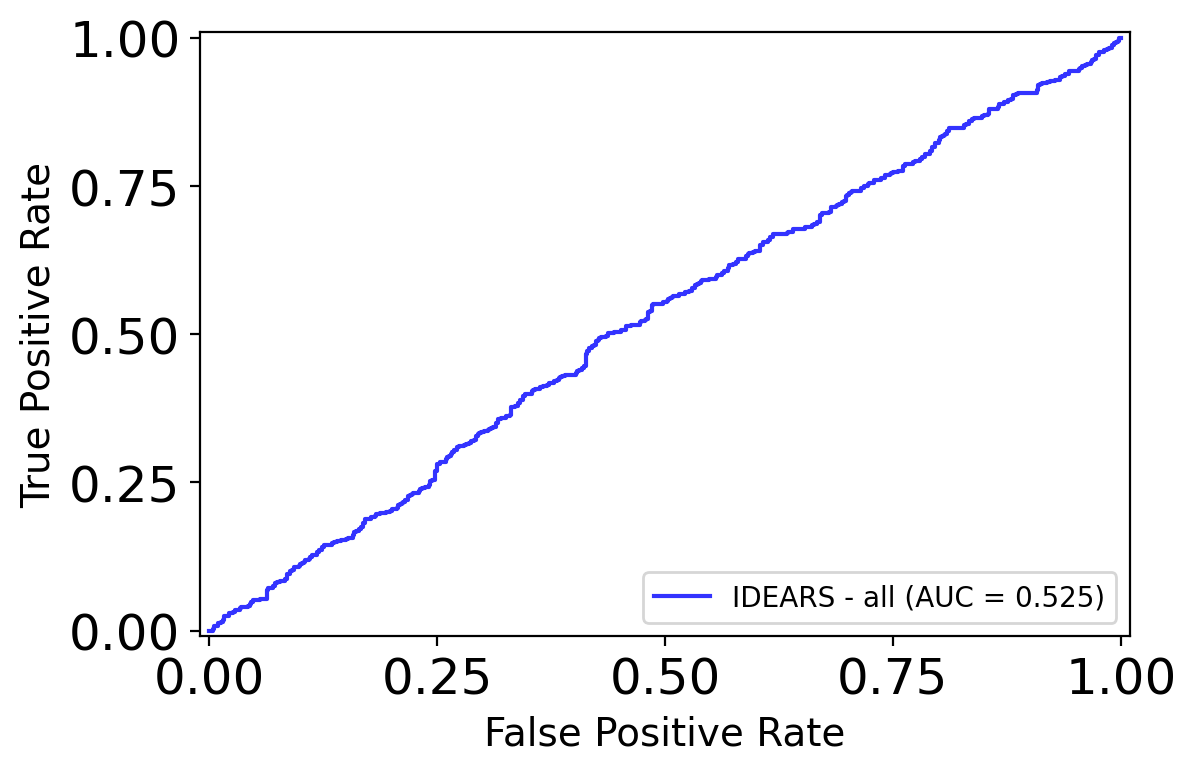

[0.5251209641945984]

In [313]:
ml.ROCAUC_tuples(df_out_list=[shap_tuple_all_f[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for 3 month Pain')

<AxesSubplot:>

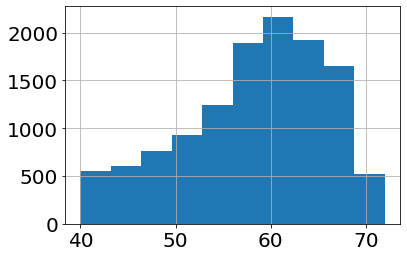

In [293]:
df_all['age_assess'].hist(bins=10)

In [272]:
df_all['pain'].mean()

0.6046416605377135

In [245]:
shap_tuple_carp,df_carp=clean_data()

Total pain_3_mths in data: 2826
Total pain_3_mths in data: 2826
3


<Figure size 2000x3000 with 0 Axes>

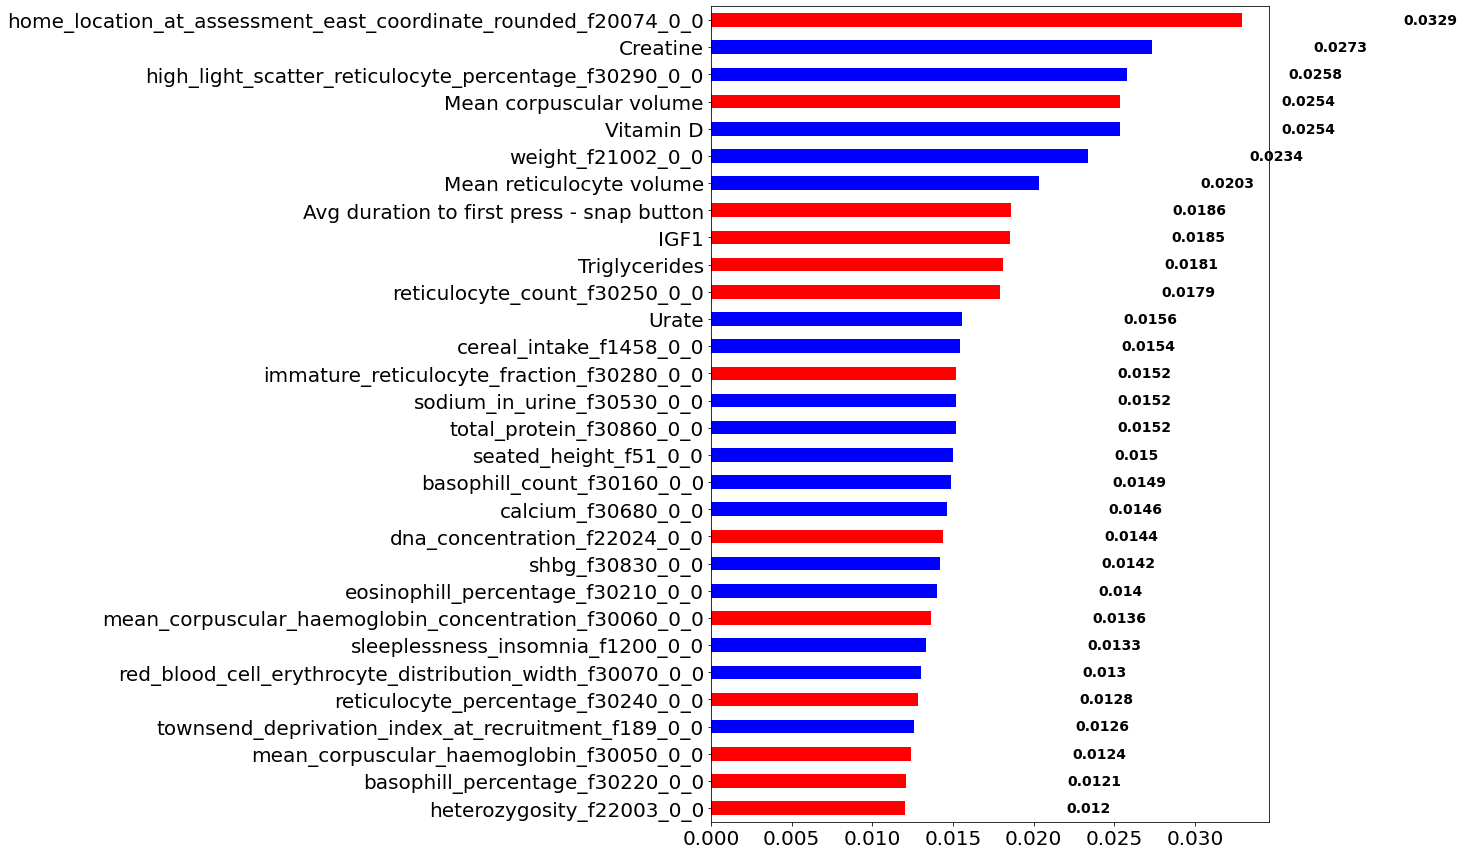

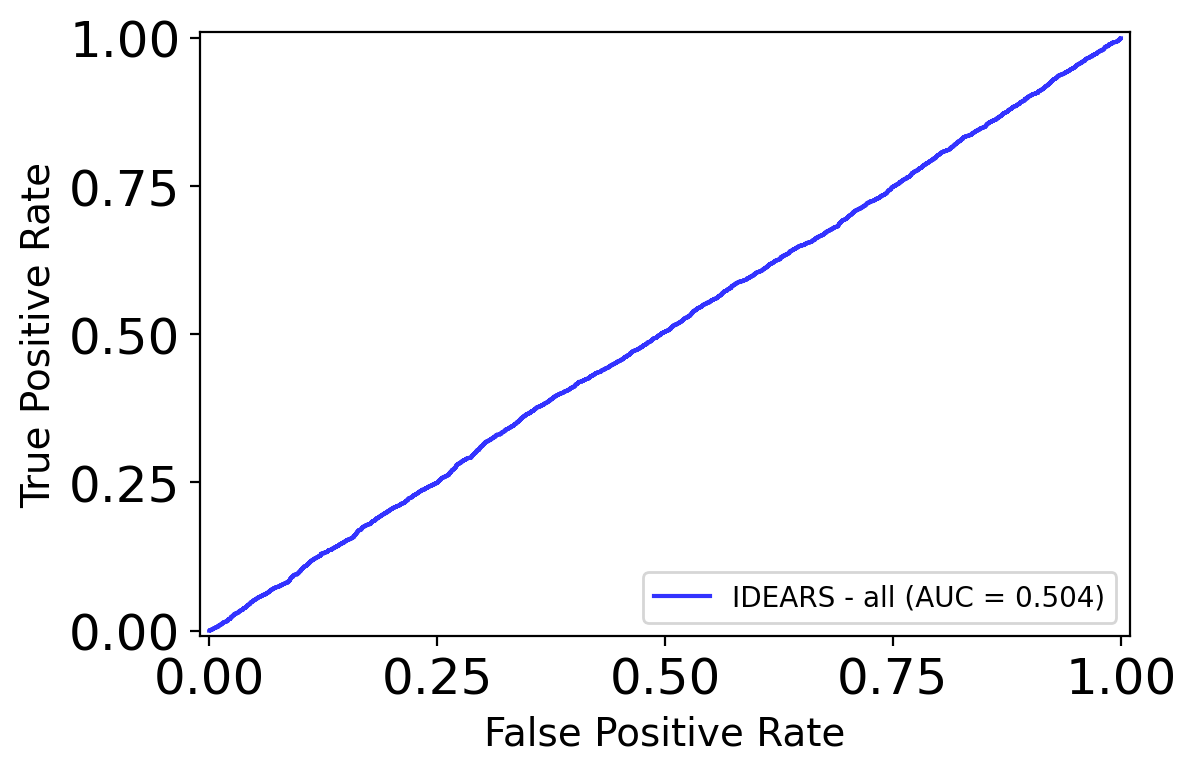

[0.5037179340357306]

In [288]:
feats_all=ml.shapgraphs_tuple(shap_tuple_all,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT pain_types_experienced')
ml.ROCAUC_tuples(df_out_list=[shap_tuple_all[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for 3 month Pain')

In [265]:
def shap_indvars_plot(df=df_carp,feats=featlinst):
    dic=dict(zip([ml.variablemap[c] for c in ml.variablemap],[c for c in ml.variablemap]))
    feats['var_orig']=feats['Variable'].map(dic)
    feats.loc[pd.isnull(feats['var_orig']),'var_orig']=feats['Variable']
    for i in range(15):

        v=np.asarray(featlinst[len(feats)-1-i:len(feats)-i]['var_orig'])[0]
        print(v)
        df.groupby('pain_3_mths')[v].mean().plot(kind='barh')
        plt.show()

total_protein_f30860_0_0


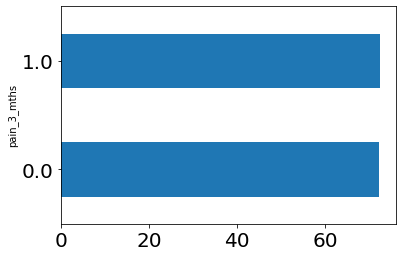

ldl_direct_f30780_0_0


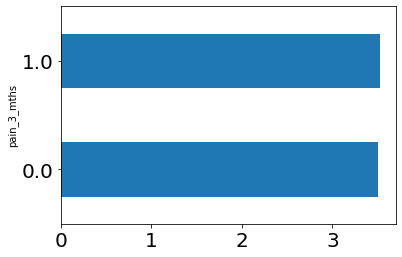

total_dis


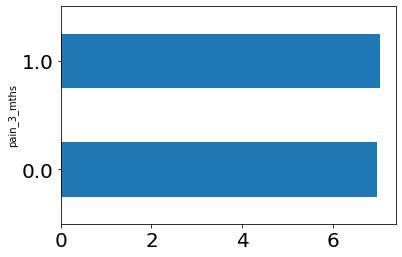

traffic_intensity_on_the_nearest_major_road_f24011_0_0


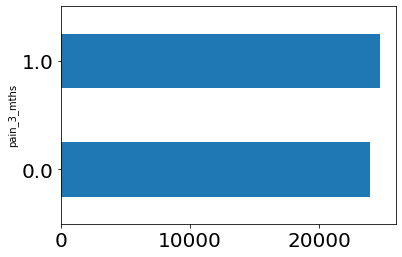

avg_duration_to_first_press_of_snapbutton_in_each_round


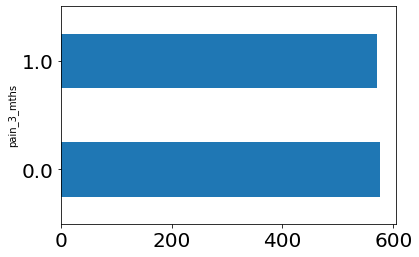

creatinine_f30700_0_0


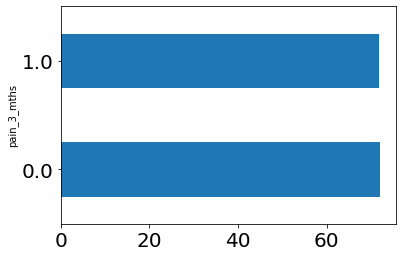

mean_corpuscular_haemoglobin_concentration_f30060_0_0


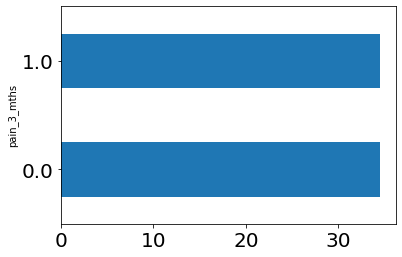

hand_grip_strength_right_f47_0_0


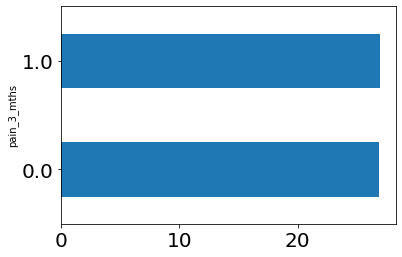

vitamin_d_f30890_0_0


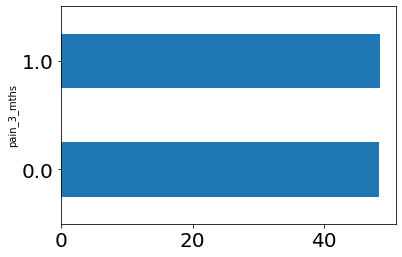

igf1_f30770_0_0


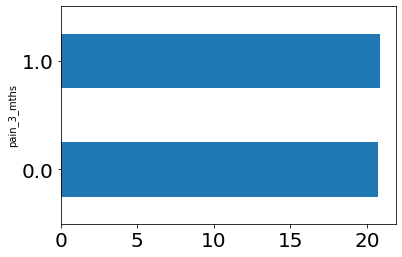

mean_sphered_cell_volume_f30270_0_0


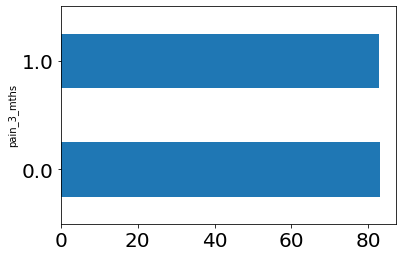

platelet_crit_f30090_0_0


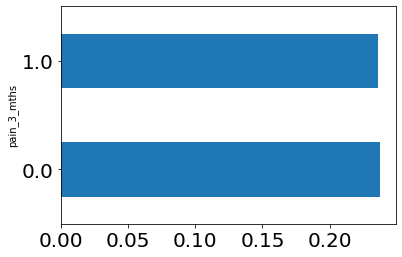

calcium_f30680_0_0


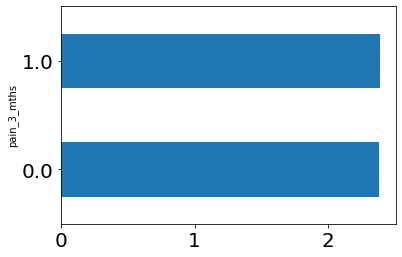

hand_grip_strength_left_f46_0_0


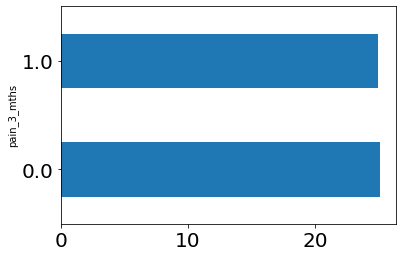

index_for_card_a_in_round_f401_0_0


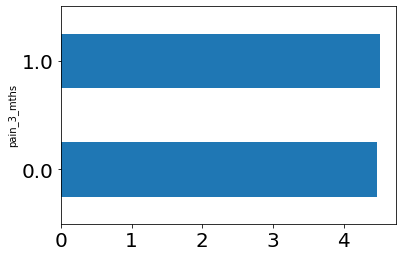

In [266]:
shap_indvars_plot(df=df_all,feats=feats_all)

<Figure size 2000x3000 with 0 Axes>

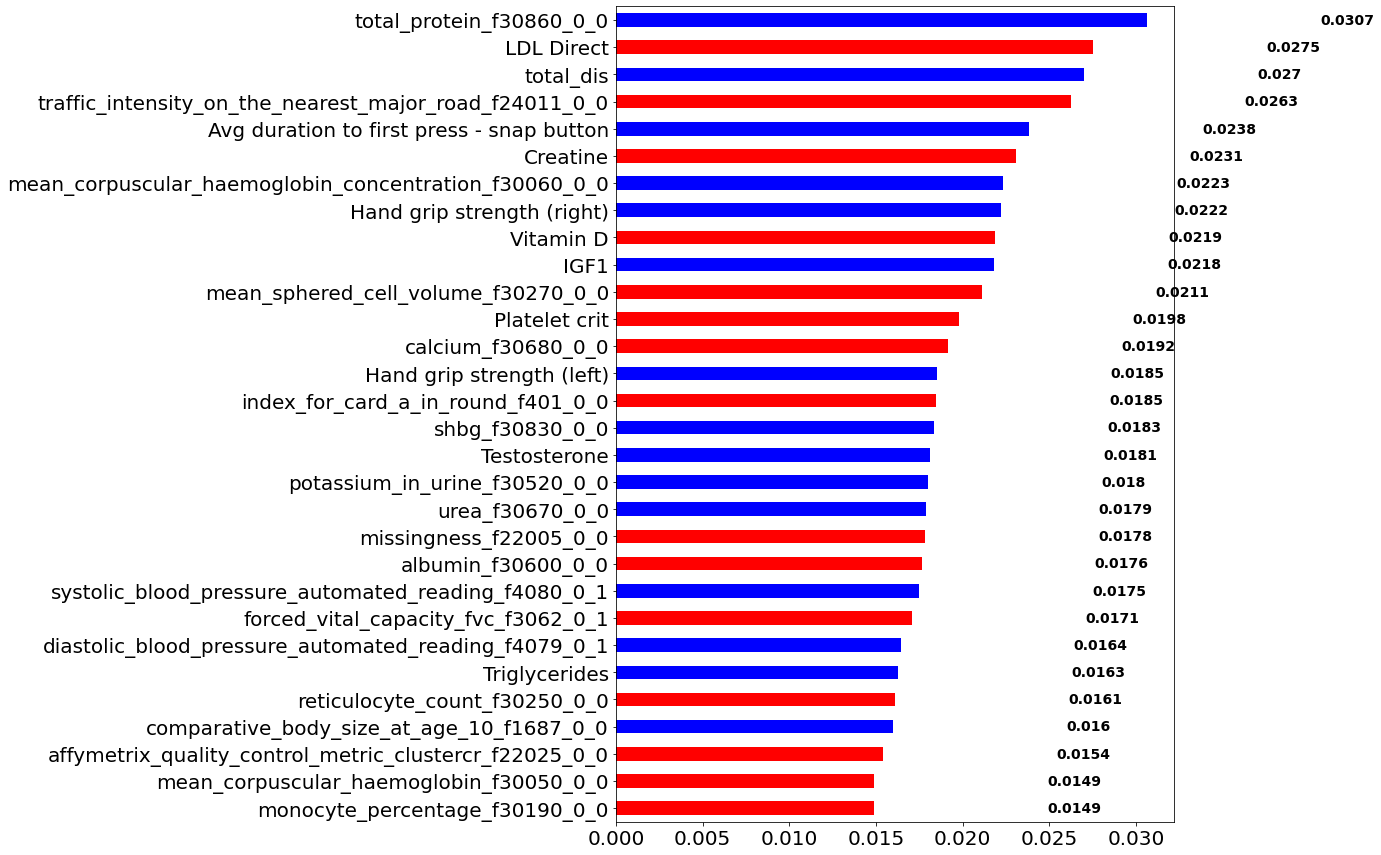

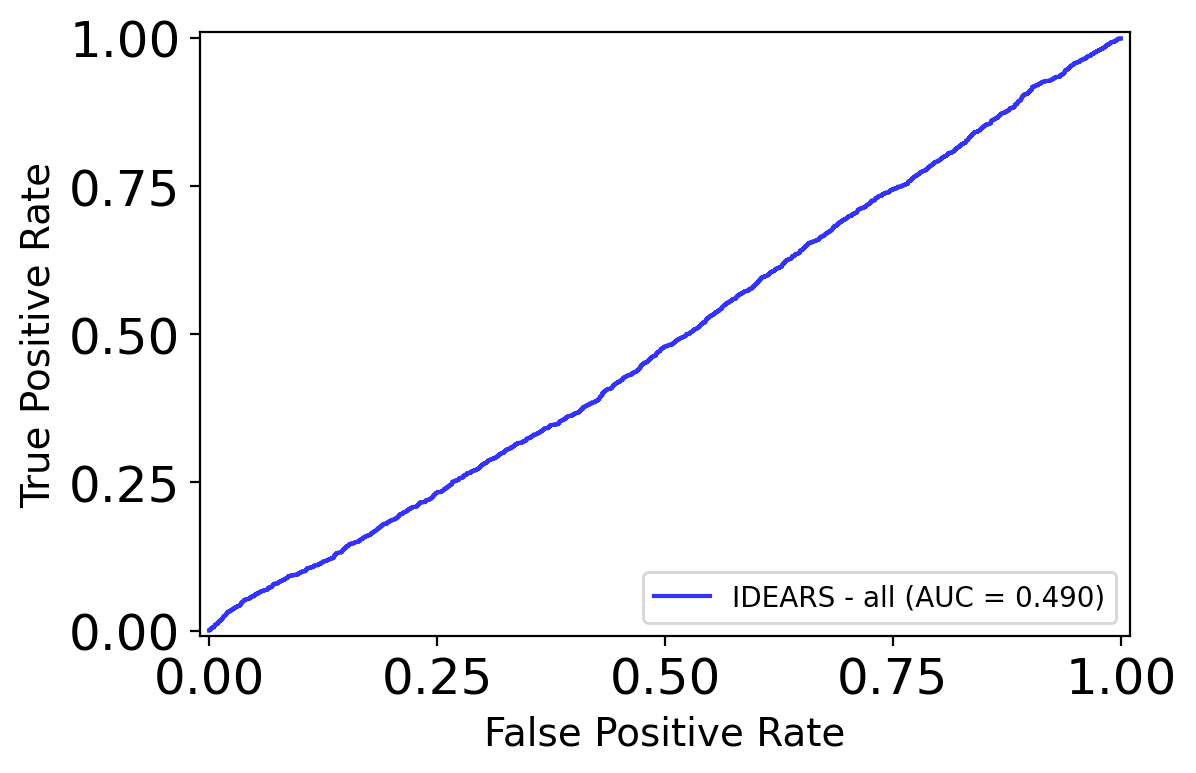

[0.4896018170085846]

In [230]:
featlinst=ml.shapgraphs_tuple(shap_tuple_carp,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT pain_types_experienced carp')
ml.ROCAUC_tuples(df_out_list=[shap_tuple_carp[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for 3 month carp Pain')

#### Merge label to full dataset

In [212]:
df_p_mod=pd.merge(df,df_p[['eid','pain']],on='eid',how='inner')
df_p_mod2=pd.merge(df,df_p[['eid','pain_3_mths']],on='eid',how='inner')
df_p_mod3=pd.merge(df,df_p_carp[['eid','pain_3_mths']],on='eid',how='inner')

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [168]:

model=ml.model()
df_p_mod=ml.col_spec_chars(df=df_p_mod)
df_p_mod2=ml.col_spec_chars(df=df_p_mod2)
df_p_mod3=ml.col_spec_chars(df=df_p_mod3)

df_p_mod=df_p_mod.loc[pd.notnull(df_p_mod['pain']),]
df_p_mod2=df_p_mod2.loc[pd.notnull(df_p_mod2['pain_3_mths']),]
df_p_mod3=df_p_mod3.loc[pd.notnull(df_p_mod3['pain_3_mths']),]

dropvars=[col for col in df_p_mod.columns if  re.search(ml.wordsremovePD,col)]
dropvars2=[col for col in df_p_mod2.columns if  re.search(ml.wordsremovePD,col)]
dropvars3=[col for col in df_p_mod3.columns if  re.search(ml.wordsremovePD,col)]

In [171]:
df_p_mod3['pain_3_mths']

Series([], Name: pain_3_mths, dtype: float64)

In [170]:
shap_tuple_carp=ml.run_entire_data_pd(df=df_p_mod3,drops=dropvars3,wordsremove='consultant',outfile='test_pain',savefile=False,
		save_featslist=False,runs=2,holdout_ratio=0.5,depvar='pain_3_mths',agemin=10,agemax=90,resize=0,resizeratio=1,verbose=False)

Total pain_3_mths in data: 0
[14:31:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1190: Empty dataset at worker: 0
[14:31:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1190: Empty dataset at worker: 0
[14:31:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1190: Empty dataset at worker: 0
[14:31:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1190: Empty dataset at worker: 0
[14:31:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1190: Empty dataset at worker: 0
[14:31:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-45

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [112]:
shap_tuple=ml.run_entire_data_pd(df=df_p_mod,drops=dropvars,wordsremove='consultant',outfile='test_pain',savefile=False,
		save_featslist=False,runs=2,holdout_ratio=0.5,depvar='pain',agemin=10,agemax=90,resize=0,resizeratio=1,verbose=False)

Total pain in data: 7399
Total pain in data: 7399
3


<AxesSubplot:ylabel='pain_3_mths'>

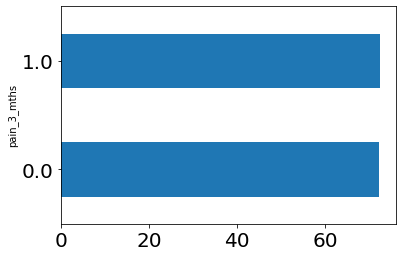

In [149]:
df_p_mod2.groupby('pain_3_mths')['total_protein_f30860_0_0'].mean().plot(kind='barh')

In [148]:
dp.findcols(df_p_mod,'prote')

['use_of_sunuv_protection_f2267_0_0',
 'apolipoprotein_a_f30630_0_0',
 'apolipoprotein_b_f30640_0_0',
 'creactive_protein_f30710_0_0',
 'total_protein_f30860_0_0',
 'Gestational _pregnancy-induced_ hypertension without significant proteinuria']

In [114]:
shap_tuple2=ml.run_entire_data_pd(df=df_p_mod2,drops=dropvars,wordsremove='consultant',outfile='test_pain',savefile=False,
		save_featslist=False,runs=1,holdout_ratio=0.5,depvar='pain_3_mths',agemin=10,agemax=90,resize=0,resizeratio=1,verbose=False)

Total pain_3_mths in data: 4940
3


<Figure size 2000x3000 with 0 Axes>

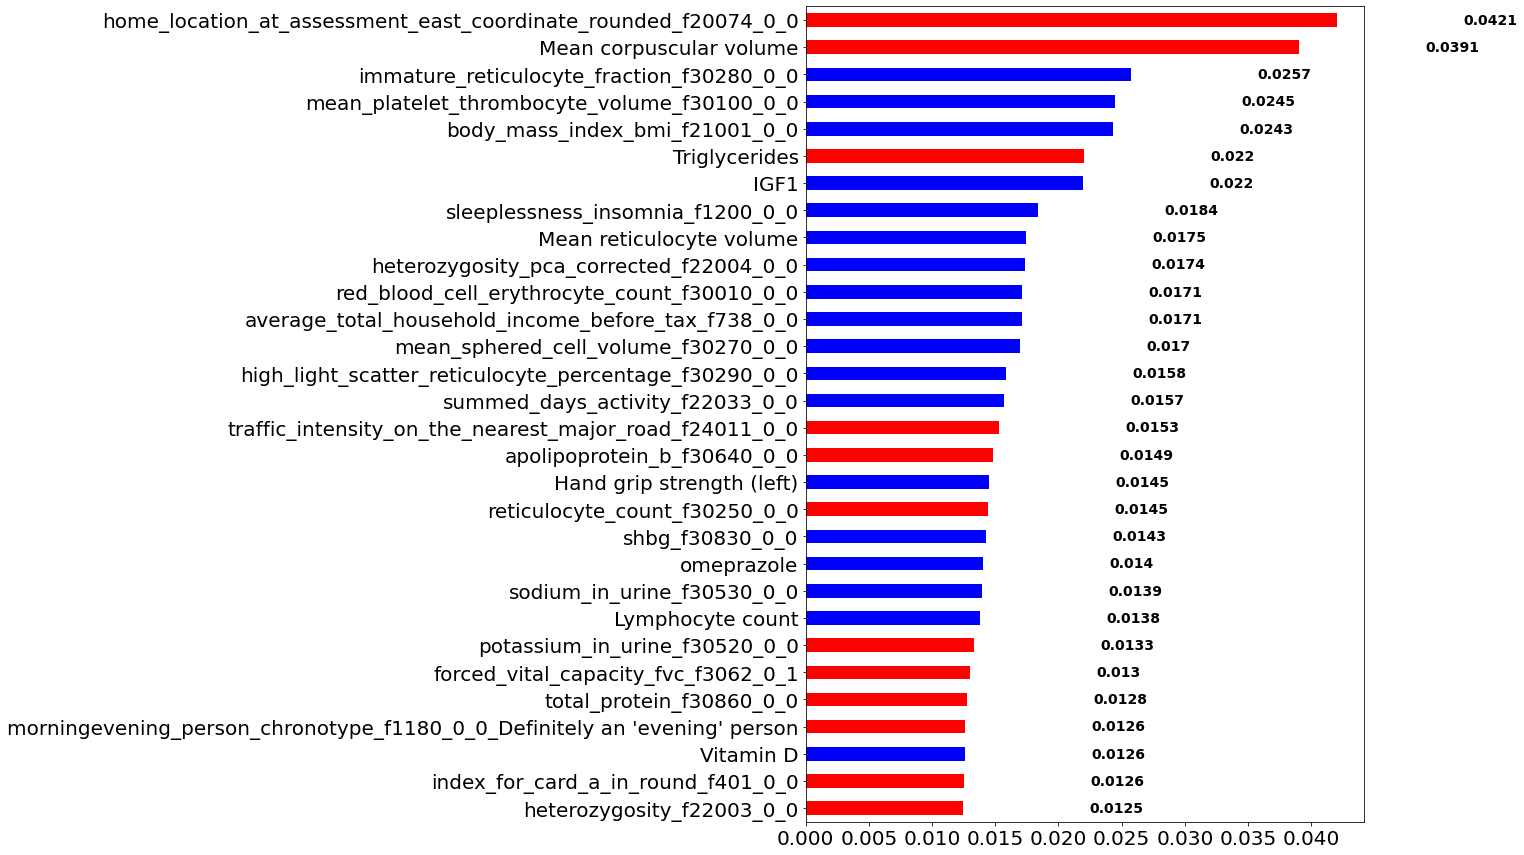

,Variable,SHAP_abs,Corr,Sign
816,Intestinal adhesions _bands_ with obstruction ...,0.000000,0.000000,blue
1075,Other specified cardiac arrhythmias,0.000000,0.000000,blue
1074,Other specified bacterial intestinal infections,0.000000,0.000000,blue
1073,Other specified bacterial agents as the cause ...,0.000000,0.000000,blue
1072,Other specified abnormal uterine and vaginal b...,0.000000,0.000000,blue
...,...,...,...,...
169,body_mass_index_bmi_f21001_0_0,0.024346,-0.513837,blue
210,mean_platelet_thrombocyte_volume_f30100_0_0,0.024468,-0.070460,blue
248,immature_reticulocyte_fraction_f30280_0_0,0.025719,-0.164509,blue
198,Mean corpuscular volume,0.039069,0.567799,red


In [136]:
ml.shapgraphs_tuple(shap_tuple,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT pain_types_experienced')

<Figure size 2000x3000 with 0 Axes>

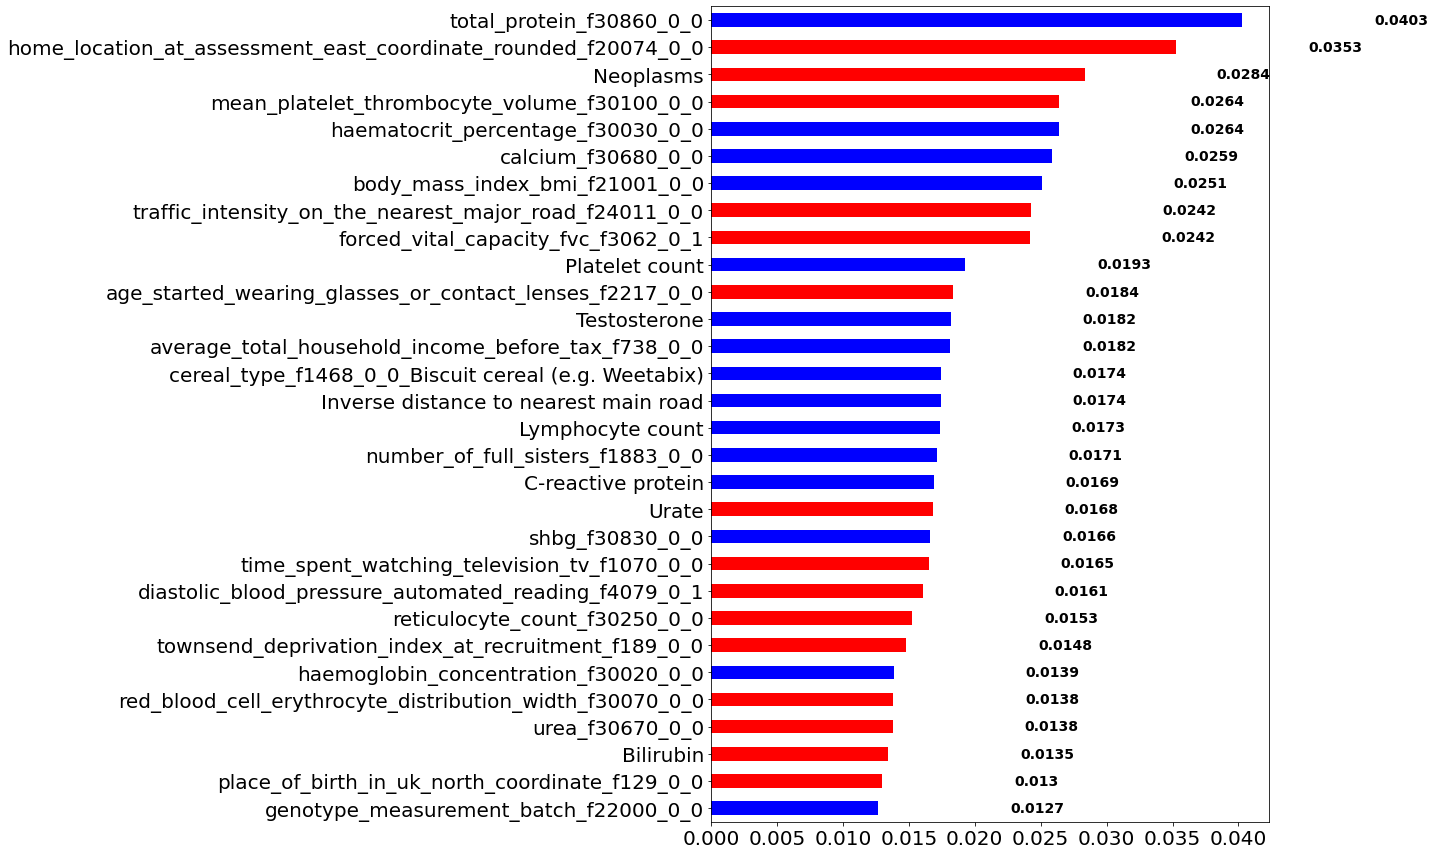

,Variable,SHAP_abs,Corr,Sign
0,worrier_anxious_feelings_f1980_0_0,0.000000,0.000000,blue
1076,Other specified complications of cardiac and v...,0.000000,0.000000,blue
1075,Other specified cardiac arrhythmias,0.000000,0.000000,blue
1074,Other specified bacterial intestinal infections,0.000000,0.000000,blue
1073,Other specified bacterial agents as the cause ...,0.000000,0.000000,blue
...,...,...,...,...
196,haematocrit_percentage_f30030_0_0,0.026357,-0.622958,blue
210,mean_platelet_thrombocyte_volume_f30100_0_0,0.026364,0.532471,red
1502,Neoplasms,0.028351,0.894946,red
167,home_location_at_assessment_east_coordinate_ro...,0.035278,0.795810,red


In [138]:
ml.shapgraphs_tuple(shap_tuple2,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT Pain 3 mths')

In [68]:
np.vstack(shap_tuple[0])

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.1117362e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 9.4577554e-05],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.7975225e-04]], dtype=float32)

<Figure size 2000x3000 with 0 Axes>

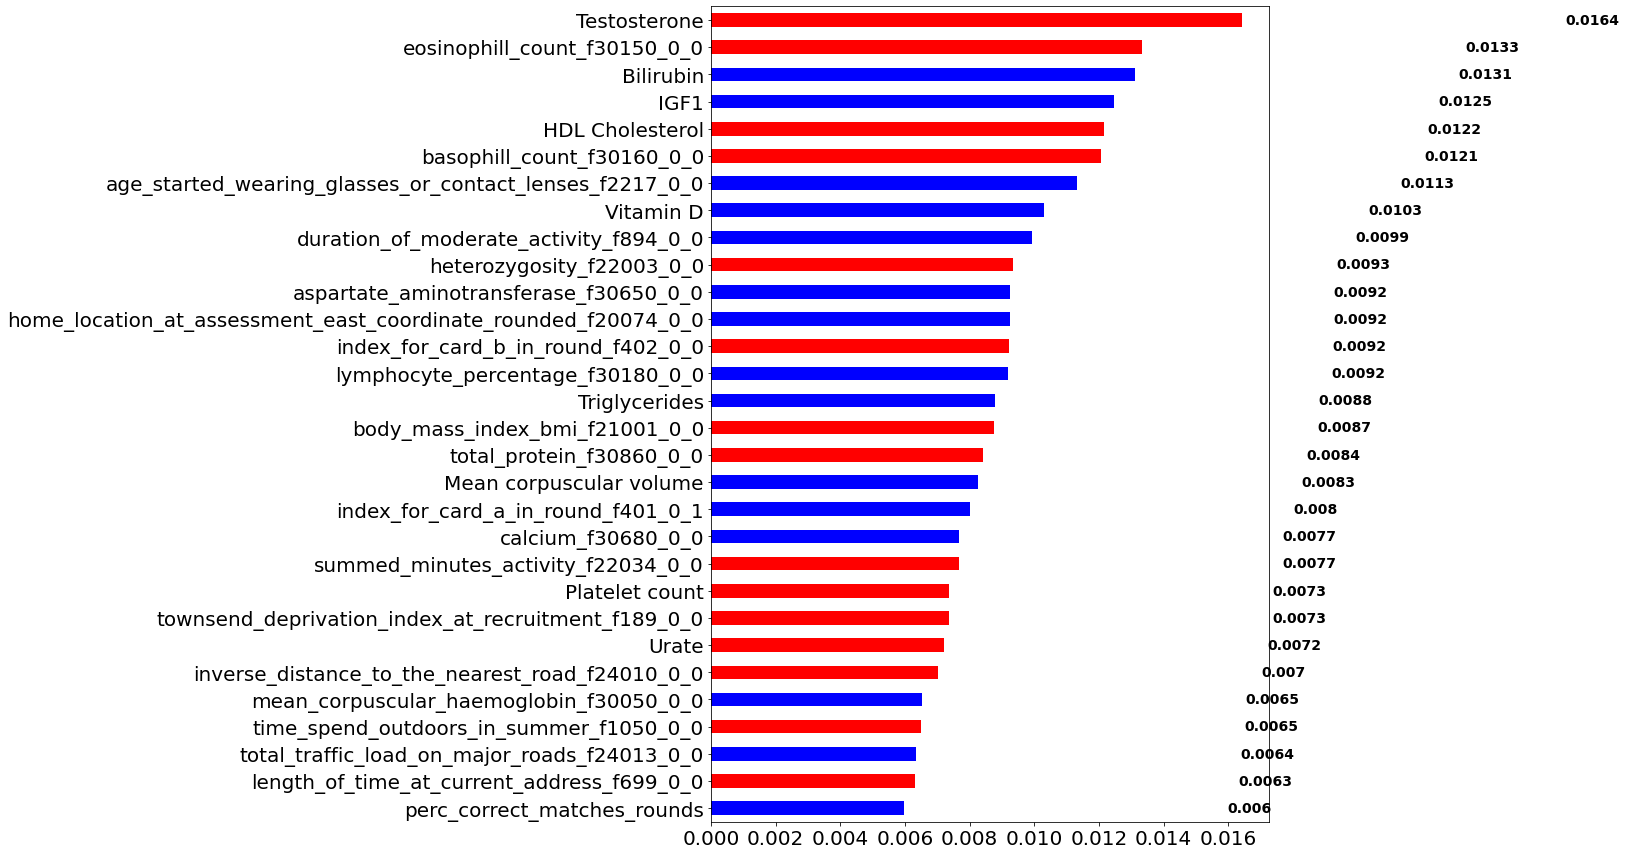

,Variable,SHAP_abs,Corr,Sign
0,worrier_anxious_feelings_f1980_0_0,0.000000,0.000000,blue
1069,Other somatoform disorders,0.000000,0.000000,blue
1068,Other signs and symptoms in breast,0.000000,0.000000,blue
1066,Other reconstructive surgery as the cause of a...,0.000000,0.000000,blue
1065,Other polyp of sinus,0.000000,0.000000,blue
...,...,...,...,...
272,HDL Cholesterol,0.012166,0.513351,red
273,IGF1,0.012476,-0.415711,blue
277,Bilirubin,0.013098,-0.299047,blue
223,eosinophill_count_f30150_0_0,0.013338,0.506235,red


In [73]:
ml.shapgraphs_tuple(shap_tuple,max_disp=30,figname='SHAP IDEARS ENTIRE COHORT Pain')

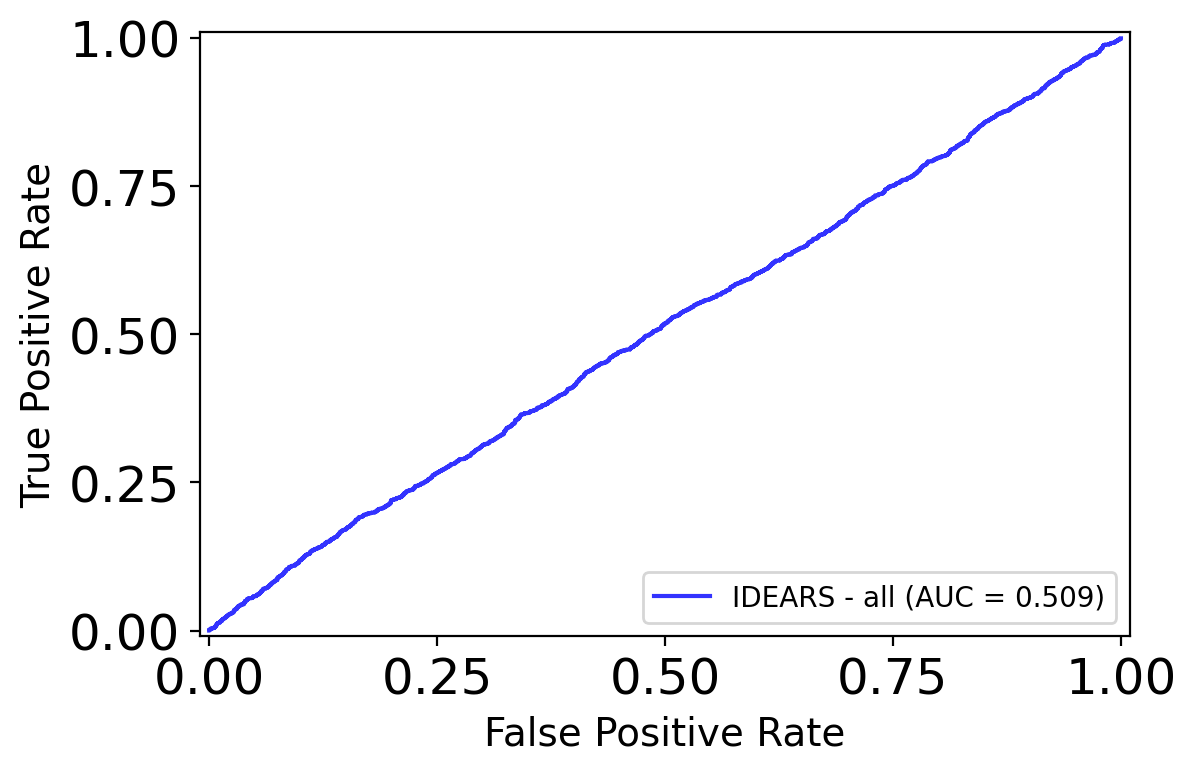

[0.509072466084239]

In [117]:
ml.ROCAUC_tuples(df_out_list=[shap_tuple2[2]],labels=['IDEARS - all'],cols=['blue'],figname='ROCAUC for 3 month Pain')

In [79]:
model=ml.model()

df_p_mod=ml.col_spec_chars(df=df_p_mod)
dropvars=[col for col in df_p_mod.columns if  re.search(ml.wordsremovePD,col)]
ml.runmodel(df=df_p_mod,dropcols=dropvars,reps=2,splits=3,model=model,depvar='pain',tree=1,plot_type='dot',featsfit=30,LRcheck=0,
				verbose=0,resize=0,resizeratio=1)

0
0.6092723290338282
Val SHAP
4109
1
0.6063519104404965
Val SHAP
4109
2
0.606960330980774
Val SHAP
4109
3
0.6063519104404965
Val SHAP
4109
4
0.610732538330494
Val SHAP
4109
5
0.605500121684108
Val SHAP
4109
6


(           eid  pain      risk  y_pred  y_test  risk_xgb  y_pred_xgb  \
 0      1000818     1  0.835955       1       1  0.880295           1   
 8      1005343     0  0.832447       1       0  0.867838           1   
 9      1005962     1  0.899211       1       1  0.897126           1   
 10     1006225     1  0.931785       1       1  0.917060           1   
 13     1006891     1  0.915517       1       1  0.906427           1   
 ...        ...   ...       ...     ...     ...       ...         ...   
 12319  6023818     1  0.855094       1       1  0.904920           1   
 12320  6024166     1  0.878231       1       1  0.907896           1   
 12324  6024791     1  0.902612       1       1  0.911781           1   
 12325  6025009     1  0.866127       1       1  0.895730           1   
 12326  6025211     0  0.890685       1       0  0.892437           1   
 
        risk_shap  y_pred_shap  
 0       0.866355            1  
 8       0.817907            1  
 9       0.882383      

In [76]:
[c for c in dropvars ]

['ever_had_samesex_intercourse_f2159_0_0',
 'birth_weight_known_f120_0_0',
 'handsfree_devicespeakerphone_use_with_mobile_phone_in_last_3_month_f1130_0_0',
 'difference_in_mobile_phone_use_compared_to_two_years_previously_f1140_0_0',
 'weekly_usage_of_mobile_phone_in_last_3_months_f1120_0_0',
 'length_of_mobile_phone_use_f1110_0_0',
 'drive_faster_than_motorway_speed_limit_f1100_0_0',
 'year_of_birth_f34_0_0',
 'time_since_interview_start_at_which_blood_pressure_screens_shown_f96_0_0',
 'time_since_interview_start_at_which_blood_pressure_screens_shown_f96_0_1',
 'time_to_complete_round_f400_0_1',
 'time_to_complete_round_f400_0_2',
 'genetic_principal_components_f22009_0_1',
 'genetic_principal_components_f22009_0_2',
 'genetic_principal_components_f22009_0_3',
 'genetic_principal_components_f22009_0_4',
 'genetic_principal_components_f22009_0_5',
 'genetic_principal_components_f22009_0_6',
 'genetic_principal_components_f22009_0_7',
 'genetic_principal_components_f22009_0_8',
 'geneti